# An overview of the data of [KIC 1430163](https://archive.stsci.edu/kepler/data_search/search.php?target=1430163&action=Search&outputformat=HTML_Table) from [Kepler](https://archive.stsci.edu/kepler/)

Written by [Pavel Sobolev](https://github.com/Paveloom) and located [here](https://github.com/Paveloom/C2).

Importing non-standard packages and modules:

[kplr](https://github.com/dfm/kplr) developed by [Daniel Foreman-Mackey](https://github.com/dfm) and other contributors;<br>
[matplotlib](https://github.com/matplotlib/matplotlib) developed by [Michael Droettboom](https://github.com/mdboom),  [Thomas Caswell](https://github.com/tacaswell) and other contributors;<br>
[autograd](https://github.com/HIPS/autograd) developed by [Dougal Maclaurin](https://dougalmaclaurin.com), [David Duvenaud](https://www.cs.toronto.edu/~duvenaud/), [Matt Johnson](http://people.csail.mit.edu/mattjj/), [Jamie Townsend](https://github.com/j-towns) and other contributors;<br>
[timeseries](https://github.com/astropy/astropy/tree/master/astropy/timeseries) module from [astropy](https://github.com/astropy/astropy) developed by contributors.

In [1]:
import kplr  # Tools for working with Kepler data

from matplotlib import rcParams as rcP  # Plot parameters
from matplotlib import pyplot as plt  # 2D Plots

from autograd import numpy as np  # Derivatives of numpy code
from astropy.timeseries import LombScargle  # Computing of the Lomb-Scargle Periodogram

Setting plot parameters:

In [2]:
# A magic command to get inline plots within a Python Notebook
%matplotlib inline

# A magic command to enable 2x plots
%config IPython.matplotlib.backend = "retina"

# Setting the DPIs of figures
rcP["savefig.dpi"] = 300
rcP["figure.dpi"] = 300

# Setting the Computer Modern Bright font
rcP["text.usetex"] = True
rcP["text.latex.preamble"] = r"\usepackage{cmbright}"

# Setting the font sizes
rcP["font.size"] = 16
rcP["legend.fontsize"] = 12

Loading sample data (errors are omitted here) from the [Kepler Input Catalog](https://archive.stsci.edu/kepler/kic.html) (field descriptors are taken from [Kepler Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf)):

In [3]:
# The ID of a star from the Kepler Input Catalog
KIC_ID = 1430163

# Attaching the kplr API
client = kplr.API()

# Getting the star data
star = client.star(KIC_ID)

# Time values
t = []

# Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux values
f = []

# The 1-sigma errors in PDC flux values
ferr = []

# Getting long cadence data of light curves
for lc in star.get_light_curves(short_cadence=False):

    # Reading data from a light curve
    data = lc.read()

    # Getting time values from the data
    t0 = data["TIME"]

    # Getting PDCSAP flux values from the data
    f0 = data["PDCSAP_FLUX"]

    # Creating a mask for only qualitative data points
    mask = (data["SAP_QUALITY"] == 0) & np.isfinite(t0) & np.isfinite(f0)

    # Appending the qualitative time data to the existing list
    t.append(t0[mask])

    # Computing the median of the flux data
    mu = np.median(f0[mask])

    # Scaling the qualitative flux data and appending these to the existing list
    f.append((f0[mask] / mu - 1.0) * 1e3)

# Concatenating the arrays within the lists

t = np.concatenate(t)
f = np.concatenate(f)

# Getting contiguous arrays

t = np.ascontiguousarray(t, dtype=float)
f = np.ascontiguousarray(f, dtype=float)

Plotting the data (errors are omitted):

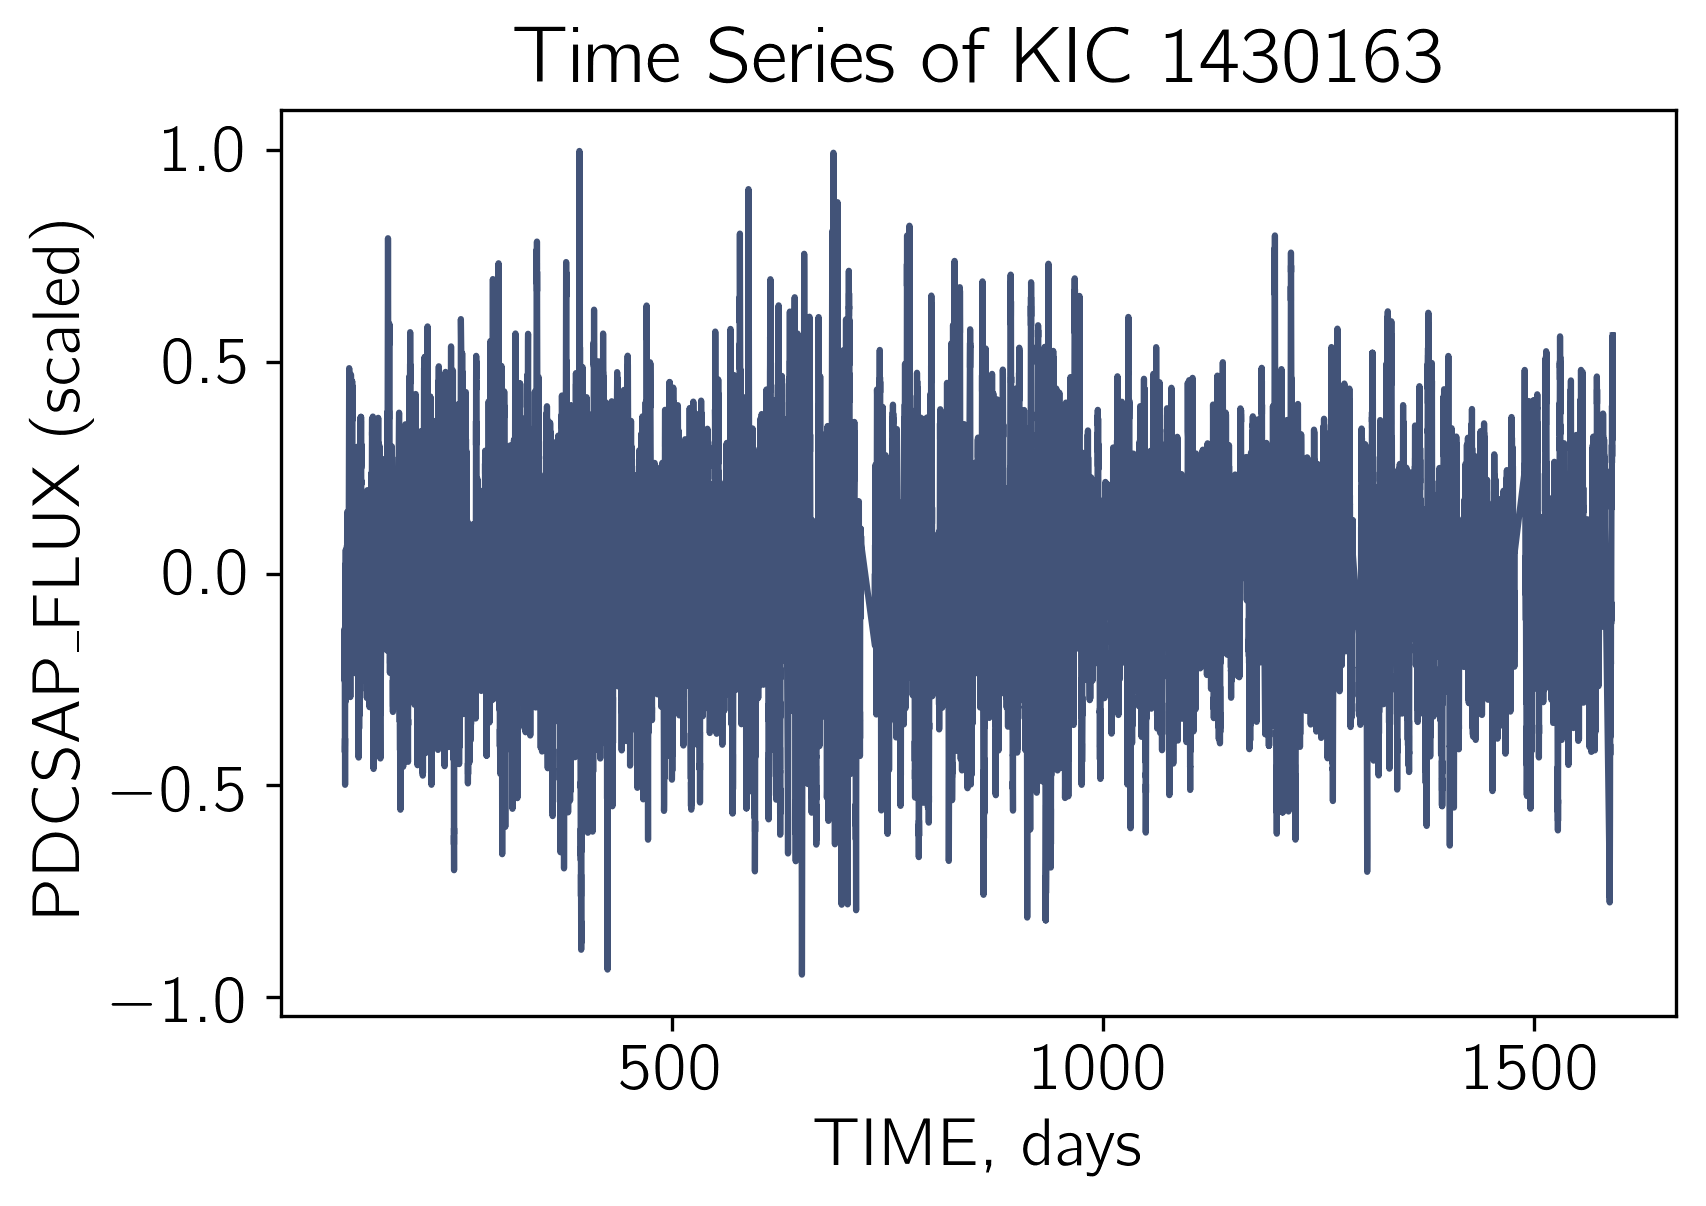

In [4]:
# Plotting the data
plt.plot(t, f, color="#425378")

# Setting labels
plt.xlabel("TIME, days")
plt.ylabel("PDCSAP\_FLUX (scaled)")

# Setting title
plt.title("Time Series of KIC 1430163")

# Saving the figure
plt.savefig("Figures/TS", bbox_inches="tight")

Plotting the Lomb-Scargle periodogram (see, e.g VanderPlas ([2017](https://www.mendeley.com/catalogue/understanding-lombscargle-periodogram-1/))) <br>and comparing a pick value to the value known from Mathur et al. ([2014](https://www.mendeley.com/catalogue/investigating-magnetic-activity-f-stars-kepler-mission/)):

The maximum peak is at 4.358326068003487


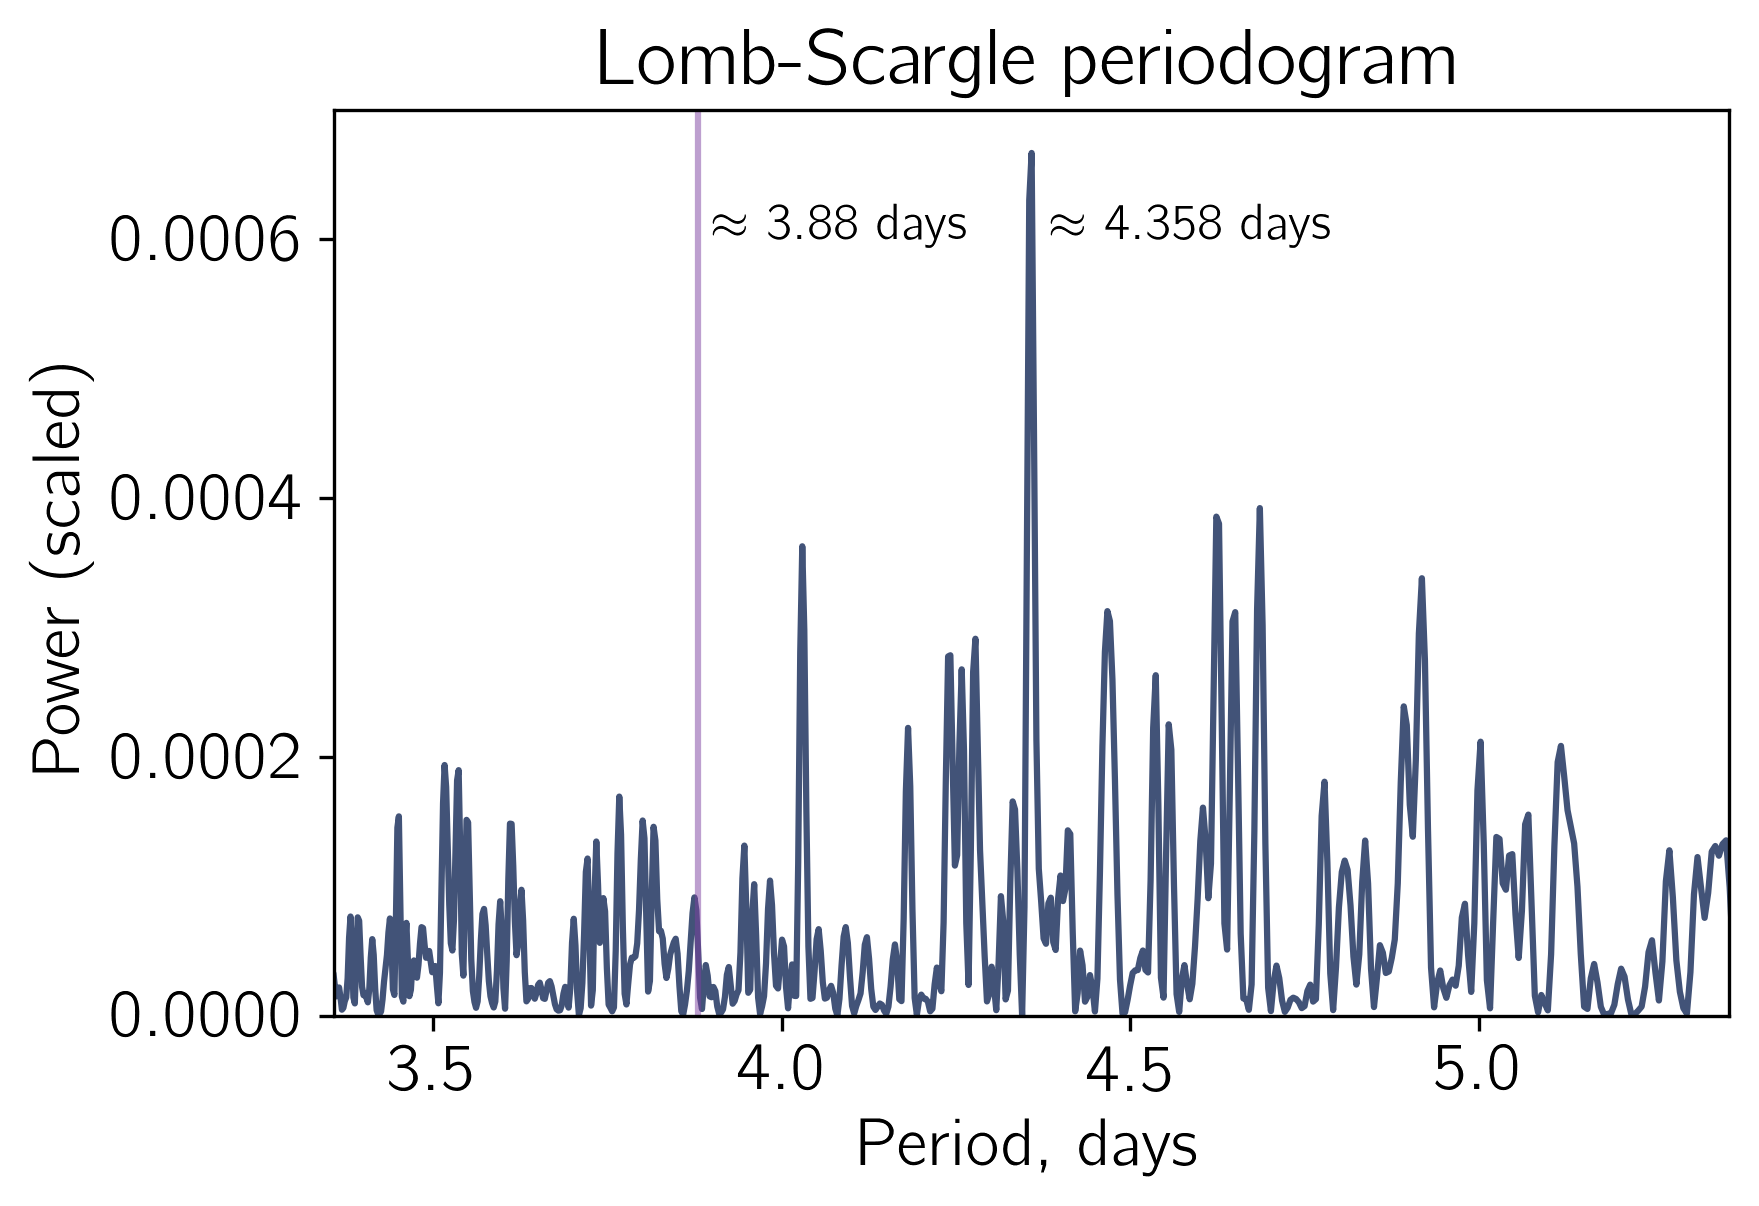

In [5]:
# Creating a set of evenly spaced frequencies
freq = np.linspace(1e-1, 1.0, 5000)

# Getting the PSD-normalized Lomb-Scargle power spectrum of the data using the fast method (O[N log N])
power = LombScargle(t, f).power(freq, method="fast", normalization="psd")

# Determining the maximum peak
period = 1.0 / freq[np.argmax(power)]

# Printing the x value of this peak
print("The maximum peak is at " + str(period))

# Scaling the output
power /= len(t)

# Plotting the result with emphasis on the period value
# and comparing it to the real value

# Plotting data
plt.plot(1.0 / freq, power, color="#425378")

# Marking the true period value
plt.axvline(3.88, color="#7C40A0", alpha=0.5)

# Adding approximate period values on the plot
plt.text(3.9, 0.0006, r"$\approx$ 3.88 days", fontsize=12)
plt.text(4.385, 0.0006, r"$\approx$ 4.358 days", fontsize=12)

# Setting limits
plt.xlim(period - 1, period + 1)
plt.ylim(0, 0.0007)

# Setting labels
plt.xlabel("Period, days")
plt.ylabel("Power (scaled)")

# Setting title
plt.title("Lomb-Scargle periodogram")

# Saving the figure
plt.savefig("Figures/LS_periodogram", bbox_inches="tight")